# Chapter 2, Parse

Ebook, A Hands-On Guide to Biomechanics Data Analysis with Python and AI  
Author, Dr. Hossein Mokhtarzadeh  
Powered by PoseIQ

Goal, turn raw files into clear, labeled data you can analyze.  
Click Runtime, Run all.


## Install packages

In [1]:
!pip -q install ezc3d pandas scipy matplotlib

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.6/49.6 kB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 29.0 MB/s eta 0:00:00


## Download sample data from c3d.org, with fallback

In [2]:
import os, urllib.request, zipfile, sys

def download_zip(url, out_path):
    try:
        print("Downloading", url)
        urllib.request.urlretrieve(url, out_path)
        return True
    except Exception as e:
        print("Download failed:", e)
        return False

os.makedirs("sample_data", exist_ok=True)
zpath = "sample_data.zip"

# Try Sample00 then Sample01 as fallback
ok = download_zip("https://c3d.org/data/Sample00.zip", zpath)
if not ok:
    ok = download_zip("https://www.c3d.org/data/Sample00.zip", zpath)
if not ok:
    ok = download_zip("https://c3d.org/data/Sample01.zip", zpath)
if not ok:
    ok = download_zip("https://www.c3d.org/data/Sample01.zip", zpath)

if not ok:
    print("Could not download sample data from c3d.org, please upload a .c3d file to the notebook runtime")
else:
    with zipfile.ZipFile(zpath, 'r') as zf:
        zf.extractall("sample_data")
    print("Extracted sample_data")
    for root, dirs, files in os.walk("sample_data"):
        for f in files:
            if f.lower().endswith((".c3d", ".trc", ".csv")):
                print("Found:", os.path.join(root, f))


Extracted sample_data
Found: sample_data/mnist_train_small.csv
Found: sample_data/california_housing_test.csv
Found: sample_data/california_housing_train.csv
Found: sample_data/mnist_test.csv
Found: sample_data/NexGen Ergonomics/test1.c3d
Found: sample_data/Codamotion/codamotion_gaitwands_19970212.c3d
Found: sample_data/Codamotion/codamotion_gaitwands_20150204.c3d
Found: sample_data/Cometa Systems/EMG Data Cometa.c3d
Found: sample_data/Motion Analysis Corporation/Sample_Jump2.c3d
Found: sample_data/Motion Analysis Corporation/Walk1.c3d
Found: sample_data/Vicon Motion Systems/pyCGM2 lower limb CGM24 Walking01.c3d
Found: sample_data/Vicon Motion Systems/TableTennis.c3d
Found: sample_data/Advanced Realtime Tracking GmbH/arthuman-sample-fingers.c3d
Found: sample_data/Advanced Realtime Tracking GmbH/arthuman-sample.c3d
Found: sample_data/Innovative Sports Training/Static Pose.c3d
Found: sample_data/Innovative Sports Training/Gait with EMG.c3d


## Load a C3D file with ezc3d

In [3]:
import numpy as np
import ezc3d, os

# Find a C3D file recursively
c3d_files = []
for root, dirs, files in os.walk("sample_data"):
    for f in files:
        if f.lower().endswith(".c3d"):
            c3d_files.append(os.path.join(root, f))

if not c3d_files:
    raise FileNotFoundError("No .c3d files found in sample_data. Upload a .c3d file and try again.")

c3d_path = c3d_files[0]
print("Loading C3D:", c3d_path)
c3d = ezc3d.c3d(c3d_path)

points = c3d["data"]["points"]   # shape, (4, n_points, n_frames)
n_points = points.shape[1]
n_frames = points.shape[2]

# Rates
point_rate = float(c3d["parameters"]["POINT"]["RATE"]["value"][0]) if "POINT" in c3d["parameters"] and "RATE" in c3d["parameters"]["POINT"] else float(c3d["header"]["points"]["frame_rate"])
time_points = np.arange(n_frames) / point_rate

# Marker labels
marker_labels = list(c3d["parameters"]["POINT"]["LABELS"]["value"]) if "POINT" in c3d["parameters"] and "LABELS" in c3d["parameters"]["POINT"] else [f"M{i}" for i in range(n_points)]
print("Number of markers:", n_points)
print("First 10 marker labels:", marker_labels[:10])


Loading C3D: sample_data/NexGen Ergonomics/test1.c3d
Number of markers: 40
First 10 marker labels: ['C7', 'CLAV', 'LANK', 'LASI', 'LBHD', 'LELB', 'LFHD', 'LFIN', 'LFRA', 'LHEE']


## Extract and filter one marker position, mm to m

In [5]:
from scipy.signal import butter, filtfilt

# Pick a marker by name if available, fallback to first
preferred_names = ["RHEE", "RHEEL", "Heel", "RHEE1", "HEE", "HEE_R"]
marker_idx = 0
for name in preferred_names:
    if name in marker_labels:
        marker_idx = marker_labels.index(name)
        break

xyz = points[:3, marker_idx, :].T       # shape, (frames, 3)
xyz_m = xyz / 1000.0                     # mm to m

# Low pass filter, 6 Hz for kinematics
def butter_lowpass(data, cutoff_hz, fs_hz, order=4, axis=-1):
    nyq = 0.5 * fs_hz
    b, a = butter(order, cutoff_hz/nyq, btype="low")
    # Check if data is long enough for filtering
    padlen = 3 * order
    if data.shape[axis] <= padlen:
        print(f"Warning: Data length ({data.shape[axis]}) is too short for filtering with order {order}. Skipping filtering.")
        return data  # Return original data if too short
    return filtfilt(b, a, data, axis=axis)

xyz_filt = butter_lowpass(xyz_m, cutoff_hz=6, fs_hz=point_rate, order=4)
print("Filtered marker shape:", xyz_filt.shape)

Filtered marker shape: (721, 3)


## Extract analog data and labels, build analog time vector

In [6]:
# Analogs shape in ezc3d is (n_subframes, n_analogs, n_frames)
analogs = c3d["data"]["analogs"]
has_analogs = isinstance(analogs, np.ndarray) and analogs.size > 0

analog_labels = []
analog_rate = None
if "ANALOG" in c3d["parameters"]:
    par_analog = c3d["parameters"]["ANALOG"]
    # Collect LABELS, LABELS2, LABELS3 if present
    for k, v in par_analog.items():
        if k.startswith("LABELS"):
            analog_labels.extend(list(v["value"]))
    if "RATE" in par_analog:
        analog_rate = float(par_analog["RATE"]["value"][0])

if has_analogs and analog_rate:
    n_sub, n_analogs, n_frames_a = analogs.shape
    # reshape to 2D time series, channels x samples
    analogs_2d = analogs.transpose(1, 2, 0).reshape(n_analogs, n_frames_a*n_sub)
    t_analog = np.arange(analogs_2d.shape[1]) / analog_rate
    print("Analog channels:", n_analogs, "Analog rate:", analog_rate, "Hz")
    print("First 10 analog labels:", analog_labels[:10])
else:
    print("No analog data or analog rate found")


No analog data or analog rate found


## Create a tidy DataFrame with time, one marker, and one analog

In [7]:
import pandas as pd

df = pd.DataFrame({
    "Time": time_points,
    "Marker_X": xyz_filt[:, 0],
    "Marker_Y": xyz_filt[:, 1],
    "Marker_Z": xyz_filt[:, 2],
})

# Add one analog channel if available
if has_analogs and analog_rate:
    # choose first channel if labels are missing
    ch = 0
    analog_name = analog_labels[ch] if analog_labels and ch < len(analog_labels) else "Analog_0"
    # resample analog to marker time by simple decimation if rates are divisible
    n_sub = int(round(analog_rate/point_rate)) if point_rate > 0 else 1
    if n_sub >= 1 and analogs.ndim == 3 and analogs.shape[0] == n_sub:
        # take subframe 0 to match frames, simple choice for quick view
        analog_match = analogs[0, ch, :]
        df[analog_name] = analog_match[:len(df)]
    else:
        # fallback, take a simple equally spaced slice from full-rate analog
        analogs_2d = analogs.transpose(1, 2, 0).reshape(analogs.shape[1], -1)
        step = max(1, analogs_2d.shape[1] // len(df))
        analog_match = analogs_2d[ch, ::step][:len(df)]
        df[analog_name] = analog_match

print(df.head())
print(df.describe())


       Time  Marker_X  Marker_Y  Marker_Z
0  0.000000 -0.000038  0.000039  0.000084
1  0.007812 -0.000038  0.000039  0.000084
2  0.015625 -0.000038  0.000039  0.000084
3  0.023438 -0.000038  0.000039  0.000084
4  0.031250 -0.000038  0.000039  0.000084
            Time      Marker_X      Marker_Y      Marker_Z
count  721.00000  7.210000e+02  7.210000e+02  7.210000e+02
mean     2.81250 -3.772756e-05  3.897516e-05  8.351731e-05
std      1.62718  5.085726e-19  5.763823e-19  6.780968e-19
min      0.00000 -3.772756e-05  3.897516e-05  8.351731e-05
25%      1.40625 -3.772756e-05  3.897516e-05  8.351731e-05
50%      2.81250 -3.772756e-05  3.897516e-05  8.351731e-05
75%      4.21875 -3.772756e-05  3.897516e-05  8.351731e-05
max      5.62500 -3.772756e-05  3.897516e-05  8.351731e-05


## Quick plots

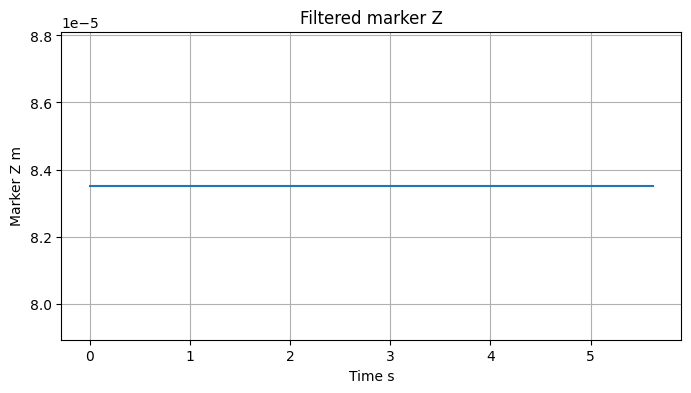

In [8]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,4))
plt.plot(df["Time"], df["Marker_Z"])
plt.xlabel("Time s")
plt.ylabel("Marker Z m")
plt.title("Filtered marker Z")
plt.grid(True)
plt.show()

# Plot analog if present
for col in df.columns:
    if col not in ["Time", "Marker_X", "Marker_Y", "Marker_Z"]:
        plt.figure(figsize=(8,4))
        plt.plot(df["Time"], df[col])
        plt.xlabel("Time s")
        plt.ylabel(col)
        plt.title(f"{col}")
        plt.grid(True)
        plt.show()
        break


## Summary

You now have a clean table with, time, marker position in meters, and one analog channel.  
Next, we will analyze events and compute gait metrics.
